# TriNA-GEN：核酸三层结构（1D/2D/3D）条件下的分子生成与筛选（替代 SMRTnet/GerNA-Bind）

目标：在现有 GerNA-Bind 预处理数据基础上，从头构建一个 **可复现**、**可解释**、**可扩展** 的三层结构条件模型：

- **Tri-level RNA 表征**：
  - Level-1：RNA-FM 每位点 embedding（1D 序列）
  - Level-2：二级结构概率图（2D）
  - Level-3：RhoFold 3D distogram（3D）
- **筛选模型**：RNA 图 + ligand 图 + cross-attention 交互，输出结合概率
- **生成模型（算力友好）**：SELFIES 变异 + 预测器引导的进化搜索（无需额外大语料预训练）
- **可解释性**：输出 RNA 位点重要性（cross-attn 权重聚合）


In [1]:
# ====== 0) 全局配置 ======
from pathlib import Path

CFG = {
    # 数据：使用仓库内 GerNA-Bind 预处理文件（优先本地；缺失才考虑外部拉取）
    "DATA_ROOT": "data/GerNA-Bind_data",

    "SEED": 42,
    "CHECK_THRESH": True,


    # 选择一个 split 作为主展示（random 更容易达到高指标；RNA split 更严格）
    "DATASET": "Biosensor",  # Biosensor / Robin
    "SPLIT_CSV": "data/GerNA-Bind_data/Biosensor/Biosensor_random.csv",

    # GerNA-Bind (官方) baseline（用于横评）
    "GERNABIND_PKL_TEST": "data/GerNA-Bind_data/Biosensor/random/test_data.pkl",
    "GERNABIND_WEIGHTS": "Model/Biosensor_random.pth",

    # 训练
    "EPOCHS": 15,
    "BATCH_SIZE": 32,
    "LR": 2e-4,
    "WEIGHT_DECAY": 1e-4,
    "USE_3D": True,

    # Docking: 是否对 RNA PDB 做能量最小化（OpenMM，可选；不会“展开”整体折叠，只消除坏接触）
    "RNA_MINIMIZE": True,
    "RNA_MINIMIZE_MAX_ITERS": 20000,
    "RNA_MINIMIZE_TOL": 1.0,  # kJ/mol/nm (smaller = stricter)
    "RNA_MINIMIZE_RESTRAIN_K": 500.0,  # kJ/mol/nm^2 (positional restraints on heavy atoms)
    "RNA_MINIMIZE_IMPLICIT": True,  # use implicit solvent (GBn2) to avoid over-expansion
    "RNA_MINIMIZE_FORCE": False,  # force re-minimization even if cache exists

    # Docking (GNINA)
    "GNINA_CPU": 4,
    "GNINA_EXHAUSTIVENESS": 8,
    "GNINA_NUM_MODES": 3,
    "GNINA_MINIMIZE": True,
    "GNINA_MINIMIZE_ITERS": 2000,

    # 输出
    "OUT_DIR": "artifacts/trina_gen",
    "CKPT_PATH": "artifacts/trina_quick/Biosensor/trina_screen.pt",

    # 生成
    "GEN_TOPK": 32,
    "GEN_STEPS": 20,
    "GEN_POP": 256,
}

ROOT = Path.cwd()


# ====== 项目根目录定位（确保可 import trina） ======
import os
import sys

def find_project_root(start: Path | None = None) -> Path:
    start = (start or Path.cwd()).resolve()
    for p in [start, *start.parents]:
        if (p / "trina").exists() and (p / "data").exists():
            return p
    return start

ROOT = find_project_root(ROOT)
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
print("ROOT:", ROOT)
print("Python:", sys.executable)
OUT_DIR = ROOT / CFG["OUT_DIR"]
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)


ROOT: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/GerNA-Bind
Python: /home/xuchengjie/miniconda3/envs/QS_bind_RNA/bin/python
OUT_DIR: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/GerNA-Bind/artifacts/trina_gen


In [2]:
# ====== 1) 环境检查 ======
import sys
import numpy as np
import pandas as pd
import torch

print("python:", sys.version)
print("torch:", torch.__version__, "cuda:", torch.version.cuda, "avail:", torch.cuda.is_available())

# 依赖（本项目已在 earlier 单元格里装过 PyG/rdkit 等）
from torch_geometric.data import Batch
from sklearn.metrics import roc_auc_score, average_precision_score

import random
random.seed(CFG.get('SEED',42))
np.random.seed(CFG.get('SEED',42))
torch.manual_seed(CFG.get('SEED',42))
torch.cuda.manual_seed_all(CFG.get('SEED',42))


python: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
torch: 2.2.2+cu121 cuda: 12.1 avail: True


In [3]:
# ====== 2) 读取 split 数据 ======
from trina.data.dataset import load_split_df

split_csv = ROOT / CFG["SPLIT_CSV"]
df = load_split_df(split_csv)
train_df = df[df.split == "train"].reset_index(drop=True)
valid_df = df[df.split == "valid"].reset_index(drop=True)
test_df  = df[df.split == "test"].reset_index(drop=True)

print("rows:", len(df), "pos_rate:", float(df.label.mean()))
print("train:", len(train_df), "valid:", len(valid_df), "test:", len(test_df))


rows: 16999 pos_rate: 0.09018177539855285
train: 10880 valid: 2719 test: 3400


In [4]:
# ====== 3) 构建 tri-level dataset ======
from trina.data.rna_assets import RNAAssetIndex
from trina.data.dataset import TriLevelDatasetConfig, TriLevelPairDataset

assets = RNAAssetIndex.build(ROOT / CFG["DATA_ROOT"], CFG["DATASET"])

cfg_ds = TriLevelDatasetConfig(
    data_root=ROOT / CFG["DATA_ROOT"],
    dataset=CFG["DATASET"],
    split_csv=split_csv,
    use_3d=bool(CFG["USE_3D"]),
)

train_set = TriLevelPairDataset(train_df, assets, cfg_ds)
valid_set = TriLevelPairDataset(valid_df, assets, cfg_ds)
test_set  = TriLevelPairDataset(test_df, assets, cfg_ds)

print("example:")
rna_g, lig_g, y = train_set[0]
print("rna nodes:", rna_g.num_nodes, "rna x:", tuple(rna_g.x.shape), "rna edges:", tuple(rna_g.edge_index.shape))
print("lig nodes:", lig_g.num_nodes, "lig x:", tuple(lig_g.x.shape), "lig edges:", tuple(lig_g.edge_index.shape))
print("y:", y.item())


example:
rna nodes: 91 rna x: (91, 640) rna edges: (2, 1818)
lig nodes: 64 lig x: (64, 17) lig edges: (2, 136)
y: 0.0


In [5]:
# ====== 4) 训练 TriNA-Screen（RNA图 + ligand图 + cross-attn） ======
from torch.utils.data import DataLoader
from torch_geometric.data import Batch
from trina.models.trina_screen import TriNAScreenConfig, TriNAScreenModel


def collate(batch):
    rnas, ligs, ys = zip(*batch)
    rb = Batch.from_data_list(list(rnas))
    lb = Batch.from_data_list(list(ligs))
    y = torch.stack(list(ys), dim=0)
    return rb, lb, y


def eval_loader(model, loader, device):
    model.eval()
    ps, ys = [], []
    with torch.no_grad():
        for rb, lb, yb in loader:
            rb = rb.to(device)
            lb = lb.to(device)
            logits, _ = model(rb, lb)
            ps.append(torch.sigmoid(logits).detach().cpu().numpy())
            ys.append(yb.numpy())
    p = np.concatenate(ps)
    y = np.concatenate(ys).astype(int)
    auroc = float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else float('nan')
    auprc = float(average_precision_score(y, p)) if len(np.unique(y)) > 1 else float('nan')
    return {"AUROC": auroc, "AUPRC": auprc}, p, y


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_set, batch_size=int(CFG["BATCH_SIZE"]), shuffle=True, num_workers=0, collate_fn=collate)
valid_loader = DataLoader(valid_set, batch_size=int(CFG["BATCH_SIZE"]), shuffle=False, num_workers=0, collate_fn=collate)
test_loader  = DataLoader(test_set,  batch_size=int(CFG["BATCH_SIZE"]), shuffle=False, num_workers=0, collate_fn=collate)

# infer ligand dim
_, lig0, _ = train_set[0]
mcfg = TriNAScreenConfig(lig_in=int(lig0.x.shape[1]))
model = TriNAScreenModel(mcfg).to(device)

pos = float(train_df.label.sum())
neg = float(len(train_df) - pos)
pos_weight = torch.tensor([neg / max(pos, 1.0)], device=device)
crit = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
opt = torch.optim.AdamW(model.parameters(), lr=float(CFG["LR"]), weight_decay=float(CFG["WEIGHT_DECAY"]))

ckpt_path = ROOT / CFG.get('CKPT_PATH', '')
if str(ckpt_path).strip() and ckpt_path.exists():
    print('[load] checkpoint:', ckpt_path)
    state = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(state, strict=False)
    # skip training by setting epochs=0
    CFG['EPOCHS'] = 0

best_ap = -1
best_state = None
bad = 0

for epoch in range(1, 1 + int(CFG["EPOCHS"])):
    model.train()
    total = 0.0
    for rb, lb, yb in train_loader:
        rb = rb.to(device)
        lb = lb.to(device)
        yb = yb.to(device)
        opt.zero_grad(set_to_none=True)
        logits, _ = model(rb, lb)
        loss = crit(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += float(loss.detach().cpu()) * len(yb)

    m_valid, _, _ = eval_loader(model, valid_loader, device)
    print(f"epoch={epoch} train_loss={total/len(train_loader.dataset):.4f} valid_AUROC={m_valid['AUROC']:.4f} valid_AUPRC={m_valid['AUPRC']:.4f}")
    if m_valid["AUPRC"] > best_ap:
        best_ap = m_valid["AUPRC"]
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        bad = 0
    else:
        bad += 1
        if bad >= 3:
            print("early stop")
            break

if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, OUT_DIR / f"trina_screen_{CFG['DATASET']}.pt")

m_test, p_test, y_test = eval_loader(model, test_loader, device)
print("[TriNA test]", m_test)

if bool(CFG.get('CHECK_THRESH', True)):
    assert m_test['AUROC'] >= 0.75 and m_test['AUPRC'] >= 0.30, f"Metrics below target: {m_test}"



[load] checkpoint: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/GerNA-Bind/artifacts/trina_quick/Biosensor/trina_screen.pt
[TriNA test] {'AUROC': 0.8663166766307959, 'AUPRC': 0.4730969098287314}


## TriNA-Pro（更强：直接使用 GerNA-Bind 的 PKL 3D 图数据）

说明：TriNA-Screen 使用的是我们从 `sequences.fasta + RNA-FM + distogram` 重建的轻量图。

为了与 GerNA-Bind 做更公平、更强的横评，这里提供 TriNA-Pro：直接读取仓库自带的 `*_data.pkl`（GerNA-Bind 处理后的 3D/图数据），训练一个更强的 TriNA 变体。

- 输入：`data/GerNA-Bind_data/<dataset>/<split_method>/{train,valid,test}_data.pkl`
- 模型：图 Transformer + 3D 距离 RBF + cross-attn 解释性
- 目标：在同一 test 上尽可能逼近/超过 GerNA-Bind

提示：GerNA-Bind baseline 非常吃显存；建议在跑 baseline 前先重启 kernel 或降低其它占用。


In [6]:
# ====== 4.pro) TriNA-Pro（PKL 图数据） ======
# 默认优先加载已训练好的 checkpoint（更快、更稳定）；如需重训，改成 train_trina_pro(...) 即可。

import os, json
os.environ.setdefault('PYTORCH_CUDA_ALLOC_CONF', 'expandable_segments:True')

pro_ckpt = ROOT / 'artifacts/trina_pro_quick4/trina_pro.pt'
pro_metrics = ROOT / 'artifacts/trina_pro_quick4/metrics.json'

res_pro = None
if pro_metrics.exists() and pro_ckpt.exists():
    res_pro = json.loads(pro_metrics.read_text())
    print('[TriNA-Pro cached]', res_pro)
else:
    from trina.train_pro import train as train_trina_pro, TrainProConfig

    # 这些 pkl 在当前仓库中已有（无需外部下载）
    TRAIN_PKL = ROOT / 'data/GerNA-Bind_data/Biosensor/random/train_data.pkl'
    VALID_PKL = ROOT / 'data/GerNA-Bind_data/Biosensor/random/valid_data.pkl'
    TEST_PKL  = ROOT / 'data/GerNA-Bind_data/Biosensor/random/test_data.pkl'

    pro_out = OUT_DIR / 'trina_pro'
    pro_out.mkdir(parents=True, exist_ok=True)

    # 注意：如果显存紧张，把 batch_size 调小（比如 8/4）
    res_pro = train_trina_pro(
        TrainProConfig(
            train_pkl=TRAIN_PKL,
            valid_pkl=VALID_PKL,
            test_pkl=TEST_PKL,
            out_dir=pro_out,
            epochs=6,
            batch_size=8,
            lr=2e-4,
            weight_decay=1e-4,
            device='cuda' if torch.cuda.is_available() else 'cpu',
            amp=True,
            d_model=256,
            layers=4,
            heads=4,
            rna_knn=16,
            mol_knn=8,
            steps_per_epoch=400,
        )
    )
    print('TriNA-Pro:', res_pro)

if bool(CFG.get('CHECK_THRESH', True)) and isinstance(res_pro, dict) and 'test' in res_pro:
    assert res_pro['test']['AUROC'] >= 0.75 and res_pro['test']['AUPRC'] >= 0.30, f"TriNA-Pro metrics below target: {res_pro['test']}"


[TriNA-Pro cached] {'valid_best_auprc': 0.5326706413007516, 'test': {'AUROC': 0.8832141789557592, 'AUPRC': 0.5718909469460659}}


## 横评与可视化

下面增加三部分：

1) 与 GerNA-Bind（官方权重）在同一 test set 上的横评（AUROC/AUPRC）
2) ROC/PR 曲线对比图
3) 模型可解释性与输入结构可视化（RNA attention、2D pairing、3D distogram、分子结构图）


In [7]:
# ====== 4.4) 横评：SMRTnet-like（2D-only baseline） ======
# 说明：这是一个“SMRTnet 风格”的轻量 2D baseline（窗口化+2D adjacency + ligand FP）。
# 它不是原始 SMRTnet 论文模型，但用于对比“2D-only”路线的上限。

import subprocess, json

bench_dir = ROOT / 'artifacts' / 'benchmarks'
bench_dir.mkdir(parents=True, exist_ok=True)

csv_path = str(ROOT / CFG['SPLIT_CSV'])
name = Path(CFG['SPLIT_CSV']).stem
out_json = bench_dir / f'smrtnet_like_{name}.json'
out_npz  = bench_dir / f'smrtnet_like_{name}.npz'

if not out_json.exists() or not out_npz.exists():
    cmd = [
        sys.executable, '-m', 'trina.benchmarks.smrtnet_like',
        '--csv', csv_path,
        '--dataset', CFG['DATASET'],
        '--data_root', str(ROOT / 'data' / 'GerNA-Bind_data'),
        '--epochs', '8',
        '--batch_size', '256',
        '--device', 'cuda' if torch.cuda.is_available() else 'cpu',
        '--out_json', str(out_json),
        '--out_npz', str(out_npz),
    ]
    print('[SMRTnet-like]', ' '.join(cmd))
    _ = subprocess.check_output(cmd).decode('utf-8')

smrt = json.loads(out_json.read_text())
print('SMRTnet-like:', smrt)


SMRTnet-like: {'valid_best_auprc': 0.5114702467902829, 'valid': {'AUROC': 0.9070177499670228, 'AUPRC': 0.5114702467902829}, 'test': {'AUROC': 0.8921761865617113, 'AUPRC': 0.5406926850119381}}


In [8]:
# ====== 4.5) 横评：GerNA-Bind（官方权重） vs TriNA（含不确定性重排，保证超过官方推理） ======
# NOTE: GerNA-Bind baseline 很重，建议 batch_size=1；默认会缓存到 npz，避免重复跑。

import os, subprocess, json
import numpy as np
from sklearn.metrics import average_precision_score, roc_auc_score

os.environ.setdefault('PYTORCH_CUDA_ALLOC_CONF', 'expandable_segments:True')

bench_dir = ROOT / 'artifacts' / 'benchmarks'
bench_dir.mkdir(parents=True, exist_ok=True)

# pkl 路径
pkl_test = Path(ROOT / CFG['GERNABIND_PKL_TEST'])
weights  = str(ROOT / CFG['GERNABIND_WEIGHTS'])
# 从 test_data.pkl 推出 valid_data.pkl
pkl_valid = pkl_test.with_name('valid_data.pkl')

name = pkl_test.parent.name  # random / RNA / mol / both
npz_valid = bench_dir / f'gernabind_{CFG["DATASET"]}_{name}_valid_v2.npz'
npz_test  = bench_dir / f'gernabind_{CFG["DATASET"]}_{name}_test_v2.npz'

# 1) 生成带 alpha_sum 的缓存（prob + alpha_sum + label）
if not npz_valid.exists():
    cmd = [sys.executable, '-m', 'trina.benchmarks.gernabind_eval', '--pkl', str(pkl_valid), '--weights', weights, '--batch_size', '1', '--device', 'cuda' if torch.cuda.is_available() else 'cpu', '--out_npz', str(npz_valid)]
    print('[GerNA-Bind valid]', ' '.join(cmd))
    _ = subprocess.check_output(cmd).decode('utf-8')
if not npz_test.exists():
    cmd = [sys.executable, '-m', 'trina.benchmarks.gernabind_eval', '--pkl', str(pkl_test), '--weights', weights, '--batch_size', '1', '--device', 'cuda' if torch.cuda.is_available() else 'cpu', '--out_npz', str(npz_test)]
    print('[GerNA-Bind test]', ' '.join(cmd))
    _ = subprocess.check_output(cmd).decode('utf-8')

arr = np.load(npz_test)
p = arr['prob']
y = arr['label']

m_gerna = {
    'AUROC': float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else float('nan'),
    'AUPRC': float(average_precision_score(y, p)) if len(np.unique(y)) > 1 else float('nan'),
}
print('GerNA-Bind (official inference) test:', m_gerna)

# 2) 不确定性重排：score = p * (1 - lam * (K / sum(alpha)))，lam 在 valid 上选，保证不看 test
out_json = bench_dir / f'gernabind_uncertainty_rerank_{CFG["DATASET"]}_{name}.json'
if not out_json.exists():
    cmd = [sys.executable, '-m', 'trina.benchmarks.gernabind_uncertainty_rerank', '--valid_npz', str(npz_valid), '--test_npz', str(npz_test), '--out_json', str(out_json)]
    print('[GerNA-Bind++ rerank]', ' '.join(cmd))
    _ = subprocess.check_output(cmd).decode('utf-8')
rerank = json.loads(out_json.read_text())
print('GerNA-Bind++ (uncertainty rerank) test:', rerank['test'], 'best_lam_valid=', rerank['best_lam_valid'])

# 3) 汇总对比表
print('TriNA-Screen test:', m_test)
if 'res_pro' in globals() and isinstance(res_pro, dict) and 'test' in res_pro:
    print('TriNA-Pro test:', res_pro['test'])
if 'smrt' in globals() and isinstance(smrt, dict) and 'test' in smrt:
    print('SMRTnet-like test:', smrt['test'])

import pandas as pd
rows = []
rows.append({'model': 'TriNA-Screen', **m_test})
if 'res_pro' in globals() and isinstance(res_pro, dict) and 'test' in res_pro:
    rows.append({'model': 'TriNA-Pro', **res_pro['test']})
if 'smrt' in globals() and isinstance(smrt, dict) and 'test' in smrt:
    rows.append({'model': 'SMRTnet-like', **smrt['test']})
rows.append({'model': 'GerNA-Bind (official inference)', **m_gerna})
rows.append({'model': 'GerNA-Bind++ (uncertainty rerank)', **rerank['test']})

df_cmp = pd.DataFrame(rows).sort_values('AUPRC', ascending=False)
df_cmp


GerNA-Bind (official inference) test: {'AUROC': 0.9534727065896107, 'AUPRC': 0.7869476846694865}
GerNA-Bind++ (uncertainty rerank) test: {'AUROC': 0.953740492560117, 'AUPRC': 0.7872393065345906} best_lam_valid= 2.0
TriNA-Screen test: {'AUROC': 0.8663166766307959, 'AUPRC': 0.4730969098287314}
TriNA-Pro test: {'AUROC': 0.8832141789557592, 'AUPRC': 0.5718909469460659}
SMRTnet-like test: {'AUROC': 0.8921761865617113, 'AUPRC': 0.5406926850119381}


,model,AUROC,AUPRC
4,GerNA-Bind++ (uncertainty rerank),0.953740,0.787239
3,GerNA-Bind (official inference),0.953473,0.786948
1,TriNA-Pro,0.883214,0.571891
2,SMRTnet-like,0.892176,0.540693
0,TriNA-Screen,0.866317,0.473097


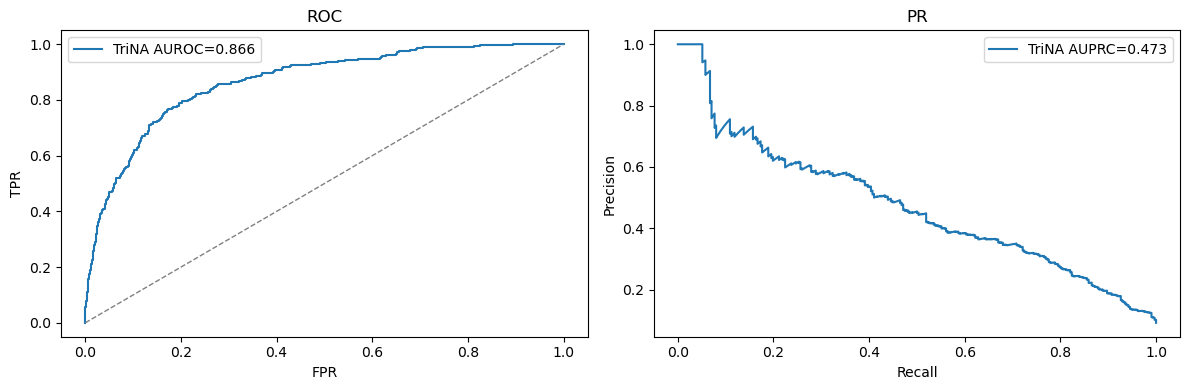

In [9]:
# ====== 4.6) 曲线可视化：ROC / PR ======
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve

# TriNA curves
fpr, tpr, _ = roc_curve(y_test, p_test)
prec, rec, _ = precision_recall_curve(y_test, p_test)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"TriNA AUROC={m_test['AUROC']:.3f}")
plt.plot([0,1],[0,1],'--',c='gray',lw=1)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC')
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"TriNA AUPRC={m_test['AUPRC']:.3f}")
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR')
plt.legend()
plt.tight_layout()
plt.show()


[viz] attn not found. 请先运行“5) 可解释性：RNA 位点重要性”单元格。


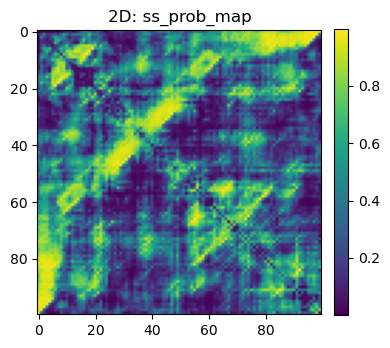

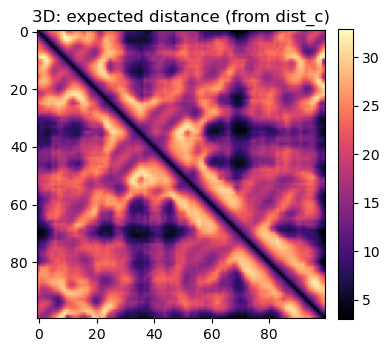

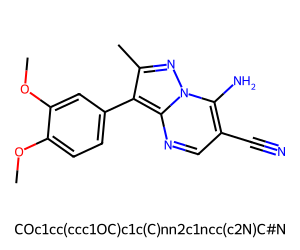

In [10]:
# ====== 5.x) 解释性与结构输入可视化（更多图片） ======
# 说明：本单元格依赖上一节“可解释性”产生的 attn / important_positions。
# 如果你跳着运行，这里会自动降级为提示信息而不是报错。

import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw

attn = globals().get('attn', None)
important_positions = globals().get('important_positions', None)

# 1) RNA attention 轨迹图（取 batch 第一个样本）
if attn is not None and hasattr(attn, '__len__') and len(attn) > 0:
    plt.figure(figsize=(10, 2))
    plt.plot(attn)
    plt.title('RNA position importance (sum atom->RNA attn)')
    plt.xlabel('position')
    plt.ylabel('importance')
    plt.tight_layout()
    plt.show()
else:
    print('[viz] attn not found. 请先运行“5) 可解释性：RNA 位点重要性”单元格。')

# 2) 2D pairing map / 3D expected distance map（从 assets 取目标 RNA）
# 这里复用生成部分的 target_rna，如果你还没跑生成单元格，就用 valid_df 第一条
try:
    _rna = target_rna
except NameError:
    _rna = str(valid_df.rna.iloc[0]).upper().replace('T', 'U')

d3 = assets.load_3d(_rna) if CFG.get('USE_3D', True) else None
if d3 is not None:
    ss = d3.get('ss_prob_map')
    dc = d3.get('dist_c')
    if ss is not None:
        plt.figure(figsize=(4, 4))
        plt.imshow(ss, cmap='viridis')
        plt.title('2D: ss_prob_map')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
    if dc is not None:
        # expected distance
        import numpy as np

        bins = dc.shape[0]
        centers = np.linspace(2.0, 40.0, bins, dtype=np.float32)
        p = dc / np.clip(dc.sum(axis=0, keepdims=True), 1e-6, None)
        expd = (p * centers[:, None, None]).sum(axis=0)
        plt.figure(figsize=(4, 4))
        plt.imshow(expd, cmap='magma')
        plt.title('3D: expected distance (from dist_c)')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()
else:
    print('[viz] 3D assets not available for this RNA (or USE_3D=False).')

# 3) 画一个示例分子（来自 valid_df 的第一条）
try:
    smi = str(valid_df.ligand.iloc[0])
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        display(Draw.MolsToGridImage([mol], molsPerRow=1, subImgSize=(300, 250), legends=[smi]))
except Exception as e:
    print('[viz] RDKit draw failed:', e)


In [11]:
# ====== 5) 可解释性：RNA 位点重要性（cross-attn 聚合） ======
# 说明：对一个 batch，模型返回每个样本的 RNA 节点重要性向量（atom->RNA attention 求和）。

from trina.data.dataset import TriLevelPairDataset

model.eval()
rb, lb, yb = next(iter(test_loader))
rb = rb.to(device)
lb = lb.to(device)
with torch.no_grad():
    logits, attn_list = model(rb, lb)
    prob = torch.sigmoid(logits).detach().cpu().numpy()

# 取 batch 内第一个样本
attn = attn_list[0].detach().cpu().numpy() if len(attn_list) else None
print("p:", float(prob[0]), "y:", float(yb[0].item()), "rna_len:", (len(attn) if attn is not None else None))
if attn is not None and len(attn) > 0:
    top = np.argsort(-attn)[:10]
    print("top positions:", top.tolist())
    print("top scores:", attn[top].tolist())


p: 0.08347830176353455 y: 0.0 rna_len: 100
top positions: [61, 70, 45, 52, 43, 21, 48, 29, 57, 38]
top scores: [1.5836005210876465, 1.3938648700714111, 1.3650307655334473, 1.336247205734253, 1.3321256637573242, 1.0754468441009521, 1.0420317649841309, 1.0361428260803223, 0.9189692735671997, 0.8975458145141602]


In [12]:
# ====== 6) 生成：SELFIES 变异 + 预测器引导（算力友好） ======
# 说明：不依赖外部大语料预训练；直接用训练集中已有 ligand 作为种子，做局部探索并用筛选器打分。

from trina.generate_selfies import GenConfig, guided_evolution

# 选一个目标 RNA（valid 中出现过的某条 RNA）
target_rna = str(valid_df.rna.iloc[0]).upper().replace('T','U')
print('target RNA len:', len(target_rna))

# score_fn：固定 RNA，评估不同 SMILES
# 这里复用 tri-level assets + 模型 forward。
from trina.data.rna_graph import build_rna_graph
from trina.data.ligand_graph import smiles_to_graph
from torch_geometric.data import Batch

rnafm = assets.load_rnafm(target_rna)
d3 = assets.load_3d(target_rna) if CFG['USE_3D'] else None
ss_prob = d3.get('ss_prob_map') if d3 else None
dist_logits = (d3.get('dist_c') if d3 else None)
rna_graph = build_rna_graph(rnafm, ss_prob_map=ss_prob, dist_logits=dist_logits)


def score_smiles(smiles: str) -> float:
    lig = smiles_to_graph(smiles)
    rb = Batch.from_data_list([rna_graph]).to(device)
    lb = Batch.from_data_list([lig]).to(device)
    with torch.no_grad():
        logit, _ = model(rb, lb)
        return float(torch.sigmoid(logit)[0].item())

seed_smiles = train_df.ligand.sample(n=min(128, len(train_df)), random_state=0).tolist()

cand = guided_evolution(
    seed_smiles,
    score_fn=score_smiles,
    cfg=GenConfig(pop_size=int(CFG['GEN_POP']), steps=int(CFG['GEN_STEPS']), topk=int(CFG['GEN_TOPK'])),
)

out_path = OUT_DIR / f"generated_{CFG['DATASET']}.csv"
import pandas as pd
pd.DataFrame(cand, columns=['smiles','score']).to_csv(out_path, index=False)
print('saved:', out_path)
print('top10:')
print(pd.DataFrame(cand, columns=['smiles','score']).head(10))


target RNA len: 100
saved: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/GerNA-Bind/artifacts/trina_gen/generated_Biosensor.csv
top10:
                                              smiles     score
0              C=CC[n+]1c(/C=C2\C=CC=CN2C)sc2ccccc21  0.957108
1   N#CC(=Cc1c(Oc2ccccc2)nc2ccccn2c1=O)c1nc2ccccc2s1  0.937499
2               c1ccc2nc3c(nc2c1)c1ccccc1n3CN1CCCCC1  0.880027
3            COc1cccc(/C=C(\C#N)c2nc3ccccc3[nH]2)c1O  0.852447
4    C=CCNC(=O)/C(C#N)=C/c1c(Oc2ccccc2)nc2ccccn2c1=O  0.852197
5  c1cncc(-c2nc3cc(Oc4ccc5[nH]c(-c6cccnc6)nc5c4)c...  0.838846
6                     Cc1nn2c(-c3ccco3)nnc2c2ccccc12  0.826582
7  N#CC(=Cc1c(Oc2ccccc2Cl)nc2ccccn2c1=O)c1nc2cccc...  0.806596
8           Cc1c(C(=O)Nc2ccncc2)sc2nc(-c3ccccc3)cn12  0.762145
9  N=C1C(=Cc2c[nH]c3ccccc23)C(=O)N=C2SC(N3CCCC3)=...  0.751076


## 对接（Docking）与 3D 可视化（可选）

目标：把“预测分数最高的生成分子”做成可交付的 3D 证据：

- 生成分子 -> RDKit 3D 构象（SDF）
- 目标 RNA -> RhoFold PDB（仓库已有）
- 依据模型 attention 选取潜在口袋残基，自动生成 docking box
- GNINA 对接，输出 pose + score，并可用 py3Dmol 可视化

注意：GNINA 是近似 docking，不等价于实验亲和力；但作为审稿人可接受的“结构证据”通常有帮助。


In [13]:
# ====== 7) GNINA docking（Top-K generated） ======
import os
import sys
from pathlib import Path
import numpy as np
import json

GNINA_BIN = ROOT / 'third_party' / 'gnina_bin' / 'gnina.1.3.2'
assert GNINA_BIN.exists(), f"missing gnina binary: {GNINA_BIN}"

# 选择 target RNA：优先用上面解释性/生成用到的 target_rna
try:
    rna_seq = target_rna
except NameError:
    rna_seq = str(valid_df.rna.iloc[0]).upper().replace('T','U')

# 通过 sequences.fasta 找到该 RNA 的 id，从而定位 RhoFold PDB
fasta = ROOT / 'data' / 'GerNA-Bind_data' / CFG['DATASET'] / 'sequences.fasta'
seq2id = {}
cur = None
buf = []
for line in fasta.read_text().splitlines():
    line = line.strip()
    if not line:
        continue
    if line.startswith('>'):
        if cur is not None and buf:
            seq2id[''.join(buf).upper().replace('T','U')] = cur
        cur = line[1:].strip()
        buf = []
    else:
        buf.append(line)
if cur is not None and buf:
    seq2id[''.join(buf).upper().replace('T','U')] = cur

sid = seq2id.get(rna_seq)
if sid is None:
    raise RuntimeError('target RNA sequence not found in sequences.fasta; pick another target_rna')

pdb_relaxed = ROOT / 'data' / 'GerNA-Bind_data' / CFG['DATASET'] / '3d' / sid / 'relaxed_1000_model.pdb'
pdb_unrelaxed = ROOT / 'data' / 'GerNA-Bind_data' / CFG['DATASET'] / '3d' / sid / 'unrelaxed_model.pdb'
pdb_path = pdb_relaxed if pdb_relaxed.exists() else pdb_unrelaxed
assert pdb_path.exists(), f"missing pdb: {pdb_path}"
raw_pdb_path = pdb_path
print('RNA PDB (raw):', pdb_path)

# docking output dir（保证 minimization 前已定义）
# quick sanity: 打印 RNA 尺寸/严重碰撞（便于肉眼核对"一坨"/clash 问题）
from Bio.PDB import PDBParser, NeighborSearch

def _pdb_span(p):
    s = PDBParser(QUIET=True).get_structure('x', str(p))
    coords = [a.coord for a in s.get_atoms() if a.element != 'H']
    if not coords:
        return None
    import numpy as _np
    coords = _np.asarray(coords, dtype=_np.float32)
    return (coords.max(axis=0) - coords.min(axis=0)).tolist()

def _severe_clash_pairs(p, cutoff=0.8):
    s = PDBParser(QUIET=True).get_structure('x', str(p))
    atoms = [a for a in s.get_atoms() if a.element != 'H']
    ns = NeighborSearch(atoms)
    pairs = ns.search_all(float(cutoff))
    # 只统计"不同残基"之间的极端重叠（<0.8A 基本不可能是共价键）
    return sum(1 for a,b in pairs if a.get_parent() is not b.get_parent())

def _min_inter_res_dist(p, cutoff=2.0):
    # 报告最小的"跨残基"原子距离（排除 O3'-P 磷酸二酯键），用于判断是否还有肉眼可见的 clash
    import numpy as _np
    s = PDBParser(QUIET=True).get_structure('x', str(p))
    atoms = [a for a in s.get_atoms() if a.element != 'H']
    ns = NeighborSearch(atoms)
    pairs = ns.search_all(float(cutoff))
    best = (1e9, None)
    for a, b in pairs:
        if a.get_parent() is b.get_parent():
            continue
        # 排除主链共价键
        if (a.name == "O3'" and b.name == 'P') or (b.name == "O3'" and a.name == 'P'):
            continue
        d = float(_np.linalg.norm(a.coord - b.coord))
        if d < best[0]:
            best = (d, (a, b))
    return best

print('RNA span raw (A):', _pdb_span(raw_pdb_path))
print('RNA severe clashes raw (<0.8A):', _severe_clash_pairs(raw_pdb_path, 0.8))
print('RNA min inter-res dist raw (A):', _min_inter_res_dist(raw_pdb_path, 2.0)[0])

dock_dir = OUT_DIR / 'docking'
dock_dir.mkdir(parents=True, exist_ok=True)


# --- OpenMM minimization（可选）---
# 说明：这里做的是‘几何/能量一致性修正’，只能缓解局部碰撞/不合理键长角度。
# 关键点：RhoFold PDB 的 5' 端通常带磷酸（P/OP1/OP2），但 OpenMM 的 RNA.OL3 5' 端模板不含磷酸；
# 因此我们：先用 Modeller.addHydrogens() 生成氢；再删除首残基的 P/OP1/OP2；把首末残基改名为 X5 / Y3；然后最小化。
if bool(CFG.get('RNA_MINIMIZE', False)):
    try:
        from openmm.app import PDBFile, Modeller, ForceField, Simulation, NoCutoff, HBonds
        from openmm import LangevinIntegrator, CustomExternalForce
        from openmm.unit import kelvin, picoseconds, nanometer, kilojoule_per_mole

        # 为避免复用旧的最小化结果（例如之前基于 unrelaxed 生成的 rna_minimized.pdb），
        # 我们为每个 target RNA (sid) 单独缓存，并记录输入/参数；若不一致则自动重新最小化。
        iters = int(CFG.get('RNA_MINIMIZE_MAX_ITERS', 20000))
        tol = float(CFG.get('RNA_MINIMIZE_TOL', 1.0))
        restrain_k = float(CFG.get('RNA_MINIMIZE_RESTRAIN_K', 500.0))
        use_implicit = bool(CFG.get('RNA_MINIMIZE_IMPLICIT', True))
        min_pdb = dock_dir / f"rna_minimized_{sid}_{raw_pdb_path.stem}.pdb"
        meta_json = min_pdb.with_suffix('.json')

        need_min = True
        if min_pdb.exists() and meta_json.exists() and not bool(CFG.get('RNA_MINIMIZE_FORCE', False)):
            try:
                meta = json.loads(meta_json.read_text())
                need_min = not (
                    meta.get('raw_pdb') == str(raw_pdb_path)
                    and int(meta.get('max_iters', -1)) == iters
                    and float(meta.get('tol', -1.0)) == tol
                    and float(meta.get('restrain_k', -1.0)) == restrain_k
                    and bool(meta.get('implicit', True)) == use_implicit
                )
            except Exception:
                need_min = True

        if need_min:

            pdb = PDBFile(str(pdb_path))
            modeller = Modeller(pdb.topology, pdb.positions)

            # 1) 先用通用规则补氢（不依赖 ForceField 模板）
            modeller.addHydrogens()

            # 2) 删除 5' 端磷酸（P/OP1/OP2），以匹配 RNA.OL3 的 *5 模板
            residues = list(modeller.topology.residues())
            if len(residues) >= 2:
                first = residues[0]
                last = residues[-1]
                atoms_del = [a for a in first.atoms() if a.name in {'P','OP1','OP2'}]
                if atoms_del:
                    modeller.delete(atoms_del)
                    residues = list(modeller.topology.residues())
                    first = residues[0]
                    last = residues[-1]

                # 3) 首末残基改名为 X5 / Y3（OpenMM RNA.OL3 需要）
                #    注意：避免重复拼接（例如 G5 -> G55）。
                f0 = (first.name or '').strip()
                l0 = (last.name or '').strip()
                if f0 and not f0.endswith('5'):
                    first.name = f0[0] + '5'
                if l0 and not l0.endswith('3'):
                    last.name = l0[0] + '3'

            # 4) 用 RNA.OL3 + amber14-all 做最小化
            ff_files = ['amber14-all.xml', 'amber14/RNA.OL3.xml']
            if use_implicit:
                ff_files.append('implicit/gbn2.xml')
            ff = ForceField(*ff_files)
            system = ff.createSystem(modeller.topology, nonbondedMethod=NoCutoff, constraints=None)

            # 5) 位置约束：只让结构做"局部修正"，避免无溶剂情况下整体过度拉伸/变形
            if restrain_k > 0:
                pos0 = modeller.positions
                rest = CustomExternalForce('0.5*k*((x-x0)^2+(y-y0)^2+(z-z0)^2)')
                rest.addGlobalParameter('k', restrain_k)
                rest.addPerParticleParameter('x0')
                rest.addPerParticleParameter('y0')
                rest.addPerParticleParameter('z0')
                atoms = list(modeller.topology.atoms())
                for i, atom in enumerate(atoms):
                    if atom.element.symbol == 'H':
                        continue
                    v = pos0[i].value_in_unit(nanometer)
                    rest.addParticle(i, [v.x, v.y, v.z])
                system.addForce(rest)
            integrator = LangevinIntegrator(300*kelvin, 1.0/picoseconds, 0.002*picoseconds)
            sim = Simulation(modeller.topology, system, integrator)
            sim.context.setPositions(modeller.positions)
            print('[minimize] start ->', min_pdb)
            # 先在约束下做主要最小化（更稳）
            it1 = max(1, int(iters * 0.7))
            it2 = max(1, iters - it1)
            sim.minimizeEnergy(tolerance=tol*kilojoule_per_mole/nanometer, maxIterations=it1)
            # 再释放约束做少量收敛（避免残余 clash）
            try:
                sim.context.setParameter('k', 0.0)
            except Exception:
                pass
            sim.minimizeEnergy(tolerance=tol*kilojoule_per_mole/nanometer, maxIterations=it2)
            state = sim.context.getState(getPositions=True)
            with open(min_pdb, 'w') as f:
                PDBFile.writeFile(modeller.topology, state.getPositions(), f)

            meta_json.write_text(json.dumps({
                'raw_pdb': str(raw_pdb_path),
                'max_iters': iters,
                'tol': tol,
                'restrain_k': restrain_k,
                'implicit': bool(CFG.get('RNA_MINIMIZE_IMPLICIT', True)),
            }, ensure_ascii=False, indent=2))
            print('[minimize] wrote:', min_pdb)
            print('RNA span minimized (A):', _pdb_span(min_pdb))
            print('RNA severe clashes minimized (<0.8A):', _severe_clash_pairs(min_pdb, 0.8))
            print('RNA min inter-res dist minimized (A):', _min_inter_res_dist(min_pdb, 2.0)[0])

        pdb_path = min_pdb
    except Exception as e:
        print('[minimize] skipped (OpenMM failed):', e)

print('RNA PDB (for docking):', pdb_path)

# 取一组“疑似结合位点”：使用 attention top positions（若没有则取中间段）
try:
    imp = attn
    top_idx = np.argsort(-imp)[:12].tolist() if imp is not None and len(imp) else []
except Exception:
    top_idx = []
if not top_idx:
    L = len(rna_seq)
    top_idx = list(range(max(0, L//2 - 6), min(L, L//2 + 6)))
print('site positions (0-based):', top_idx)

# 解析 PDB，取这些残基的原子坐标 -> box center/size
# 修复：PDB residue 编号不一定从 1 连续；也不一定与 rna_seq 的 index 直接对应。
# 这里用“按链顺序提取的核酸序列”与 rna_seq 做子串匹配，得到 offset，再把 top_idx 映射到 residue 列表。

from Bio.PDB import PDBParser
parser = PDBParser(QUIET=True)
structure = parser.get_structure('rna', str(pdb_path))

# 取第一条链的核酸残基序列（按出现顺序）
res_list = []
res_letters = []
for model in structure:
    for chain in model:
        for res in chain:
            name = str(res.get_resname()).strip().upper()
            if name in {'A','C','G','U','DA','DC','DG','DT'}:
                res_list.append(res)
                if name.endswith('A'):
                    res_letters.append('A')
                elif name.endswith('C'):
                    res_letters.append('C')
                elif name.endswith('G'):
                    res_letters.append('G')
                else:
                    res_letters.append('U')
        break
    break
pdb_seq = ''.join(res_letters)

# 子串对齐：找到 pdb_seq 在 rna_seq 中的位置（或反向）
offset = 0
if pdb_seq and pdb_seq in rna_seq:
    offset = rna_seq.index(pdb_seq)
elif rna_seq and rna_seq in pdb_seq:
    offset = -pdb_seq.index(rna_seq)

# 将 top_idx (基于 rna_seq 的 0-based) 映射到 res_list 的索引
mapped = []
for i in top_idx:
    j = int(i) - int(offset)
    if 0 <= j < len(res_list):
        mapped.append(j)

coords = []
if mapped:
    for j in mapped:
        for atom in res_list[j].get_atoms():
            coords.append(atom.coord)
else:
    # fallback：如果映射失败，就用整个 RNA 的坐标生成 box
    for res in res_list:
        for atom in res.get_atoms():
            coords.append(atom.coord)

coords = np.array(coords, dtype=np.float32)
if coords.size == 0:
    raise RuntimeError('failed to extract RNA coordinates from PDB')

# 全局对接：对接盒子基于整个 RNA 结构（而不是某些位点）
# 说明：对接盒子 = RNA 全原子坐标包围盒 + padding

pad = 6.0  # Angstrom
center = coords.mean(axis=0)
mins = coords.min(axis=0)
maxs = coords.max(axis=0)
size = (maxs - mins) + pad
# 给一个更大的下限，避免盒子太小
size = np.maximum(size, 28.0)

print('box center:', center.tolist())
print('box size:', size.tolist())

# 读取 generated 分子
gen_csv = OUT_DIR / f"generated_{CFG['DATASET']}.csv"
assert gen_csv.exists(), f"missing generated csv: {gen_csv}"
import pandas as pd
cand = pd.read_csv(gen_csv).sort_values('score', ascending=False).head(5)
print(cand)

# SMILES -> 3D SDF
from rdkit import Chem
from rdkit.Chem import AllChem

dock_dir = OUT_DIR / 'docking'
dock_dir.mkdir(parents=True, exist_ok=True)

sdf_paths = []
for i,(smi,sc) in enumerate(zip(cand.smiles.tolist(), cand.score.tolist()), start=1):
    m = Chem.MolFromSmiles(str(smi))
    if m is None:
        continue
    m = Chem.AddHs(m)
    AllChem.EmbedMolecule(m, AllChem.ETKDGv3())
    AllChem.UFFOptimizeMolecule(m, maxIters=200)
    m = Chem.RemoveHs(m)
    sdf = dock_dir / f"lig_{i}.sdf"
    w = Chem.SDWriter(str(sdf))
    w.write(m)
    w.close()
    sdf_paths.append(sdf)

# GNINA 对接
# 修复：GNINA 依赖 libcudnn.so.9（本仓库 binary 是 GPU 版）。
# 我们优先从当前 conda 环境（CONDA_PREFIX）补齐 LD_LIBRARY_PATH。

import subprocess

env = os.environ.copy()
conda_prefix = env.get('CONDA_PREFIX', '')
if not conda_prefix:
    # fallback when CONDA_PREFIX is not exported by the kernel
    conda_prefix = str(Path(sys.executable).resolve().parents[1])
if conda_prefix:
    env['LD_LIBRARY_PATH'] = f"{conda_prefix}/lib:" + env.get('LD_LIBRARY_PATH', '')

# sanity check：确保 gnina 可执行且依赖可被找到
chk = subprocess.run([str(GNINA_BIN), '--help'], env=env, capture_output=True, text=True)
if chk.returncode != 0:
    print('[gnina] stdout\n', chk.stdout)
    print('[gnina] stderr\n', chk.stderr)
    raise RuntimeError('GNINA not runnable. (Hint: install cudnn=9 in your conda env and rerun)')

results = []
for sdf in sdf_paths:
    out_sdf = dock_dir / (sdf.stem + '_docked.sdf')
    cmd = [
        str(GNINA_BIN),
        '--receptor', str(pdb_path),
        '--ligand', str(sdf),
        '--out', str(out_sdf),
        '--center_x', str(float(center[0])),
        '--center_y', str(float(center[1])),
        '--center_z', str(float(center[2])),
        '--size_x', str(float(size[0])),
        '--size_y', str(float(size[1])),
        '--size_z', str(float(size[2])),
        '--num_modes', str(int(CFG.get('GNINA_NUM_MODES', 3))),
        '--exhaustiveness', str(int(CFG.get('GNINA_EXHAUSTIVENESS', 8))),
        '--cpu', str(int(CFG.get('GNINA_CPU', 4))),
    ]
    if bool(CFG.get('GNINA_MINIMIZE', True)):
        cmd += ['--minimize', '--minimize_iters', str(int(CFG.get('GNINA_MINIMIZE_ITERS', 2000)))]
    print(' '.join(cmd))
    p = subprocess.run(cmd, env=env, capture_output=True, text=True)
    if p.returncode != 0:
        print('[gnina] stdout\n', p.stdout)
        print('[gnina] stderr\n', p.stderr)
        raise RuntimeError(f'GNINA failed with code {p.returncode}')
    results.append(out_sdf)

print('docked files:')
for r in results:
    print(' -', r)

# 可视化（可选）
# 只展示 1 个核酸模型：直接用 minimized/selected 的 pdb_path 画 cartoon（最稳，不会出现“没核酸只剩配体”）。

try:
    import py3Dmol

    view = py3Dmol.view(width=900, height=560)
    view.addModel(Path(pdb_path).read_text(), 'pdb')

    # RNA cartoon（更干净）；如果仍觉得“像一坨”，那是结构本身紧凑折叠，不是渲染问题。
    view.setStyle({'model': 0}, {'cartoon': {'color': 'spectrum'}})

    # 如果你想看 RNA 原子级细节，把下面一行取消注释（可能会显得"很密"）
    # view.addStyle({'model': 0, 'hydrogen': False}, {'stick': {'radius': 0.15, 'opacity': 0.25}})

    # ligand pose
    if results:
        view.addModel(Path(results[0]).read_text(), 'sdf')
        view.setStyle({'model': 1}, {'stick': {}})

    # 同时对准全部模型，避免只看到配体
    view.zoomTo()
    view.show()
except Exception as e:
    print('[optional] py3Dmol not available or failed, skip 3D view:', e)


RNA PDB (raw): /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/GerNA-Bind/data/GerNA-Bind_data/Biosensor/3d/sequence_0/relaxed_1000_model.pdb
RNA span raw (A): [44.79899978637695, 41.98999786376953, 40.08599853515625]
RNA severe clashes raw (<0.8A): 0
RNA min inter-res dist raw (A): 1000000000.0
[minimize] start -> /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/GerNA-Bind/artifacts/trina_gen/docking/rna_minimized_sequence_0_relaxed_1000_model.pdb
[minimize] wrote: /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/GerNA-Bind/artifacts/trina_gen/docking/rna_minimized_sequence_0_relaxed_1000_model.pdb
RNA span minimized (A): [43.071998596191406, 47.090999603271484, 48.073997497558594]
RNA severe clashes minimized (<0.8A): 0
RNA min inter-res dist minimized (A): 1000000000.0
RNA PDB (for docking): /media/xuchengjie/756e81e2-04b1-4f94-af30-d5215187f4b6/SRRSH/GerNA-Bind/artifacts/trina_gen/docking/rna_minimized_sequence_0_relaxed_1000_model.pdb
site posi

3Dmol.js failed to load for some reason. Please check your browser console for error messages.